##### Author: Aleksandrs Baskakovs <aleks@mgmt.au.dk>

# Reasoning through the embedding space

## Load libraries

In [2]:
# Default
import os
sys.path.append(os.path.abspath(".."))
import re
import random
import pickle
from pathlib import Path
from typing import Optional
from collections import Counter, defaultdict
from tqdm import tqdm
import numpy as np
import torch

# HuggingFace
from datasets import load_dataset
from dotenv import load_dotenv
from huggingface_hub import login

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import splprep, splev
sns.set(style="whitegrid", context="notebook", font_scale=1.2)

# ML
from transformers import AutoModelForCausalLM, AutoTokenizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

# Local Import
from thoughtminers import ThoughtMiner

## Load the dataset

In [4]:
login(token="YOUR TOKEN HERE")  # Login to Hugging Face Hub
dataset = load_dataset("SynthLabsAI/Big-Math-RL-Verified", split = "train")

README.md:   0%|          | 0.00/6.31k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/32.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/251122 [00:00<?, ? examples/s]

In [ ]:
# Dataset creation

source = "big_math"
problem_type = "Math Word Problems"

filtered_problems = [
    ex for ex in dataset
    if ex.get("source") == source
    and ex["domain"] and any(problem_type in d for d in ex["domain"])
]

print(f"Found {len(filtered_problems)} {problem_type} problems from {source} dataset.")

# Only filter problems to which answers are purely numeric

def is_numeric_answer(ans):
    # Remove whitespace and latex markers
    clean = ans.strip()
    # Remove possible dollar signs or LaTeX markers
    clean = re.sub(r'^\$|\$$', '', clean)
    # Accept: integers, floats, and optionally negative numbers
    return re.fullmatch(r'-?\d+(\.\d+)?', clean) is not None

dataset_farming = [
    ex for ex in filtered_problems
    if ex.get("source") == source  # or whichever dataset(s) you want
    and ex["answer"] and is_numeric_answer(ex["answer"])
]

print(f"Found {len(dataset_farming)} problems with numeric answers in {source} for {problem_type}.")

# Peek into some of the problems if desired
for i, ex in enumerate(dataset_farming[:3]):
    print(f"\nExample {i+1}")
    print("Domain: ", ex["domain"])
    print("Source:", ex.get("source", "N/A"))
    print("Problem:\n", ex["problem"])
    print("Answer:\n", ex["answer"])

## Load the model & the tokenizer

In [7]:
# Set device (use GPU if available, otherwise fallback to CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load model and tokenizer
model_id = "Qwen/Qwen2.5-3B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    trust_remote_code=True,
    torch_dtype=torch.bfloat16
)

tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.6k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

## Initialize the ThoughtMiner class

In [8]:
miner = ThoughtMiner(
    model=model,
    tokenizer=tokenizer,
    max_length=2048,     # override if you want shorter/longer outputs
    top_k=50,            # override to control sampling
    temperature=0.8      # override to make outputs more random
)

### Running an exemplary question through our miner

In [9]:
# Set up the prompt
prompt_style = """
You are MathSolver, an expert in detailed step-by-step mathematical reasoning.

**Instructions:**
1. Chain of thought:
   - Provide your reasoning in short, clear paragraphs.
   - Separate each reasoning paragraph with exactly one blank line.

2. Final answer:
   - After your reasoning, insert exactly one blank line.
   - Then, on a new line, output **only the final numerical answer**. Do **not** include any words, symbols, or explanations. Output just the number. 

Problem:
{problem}
"""

In [10]:
# Pick one question example
question_number = 3
ex = dataset_farming[question_number]
p = ex["problem"]
prompt = prompt_style.format(problem=p)

inputs = tokenizer([prompt], return_tensors="pt").to(model.device)

# input length
input_length = inputs.input_ids.shape[1]

In [11]:
# Run the question through our model and get the desired number of responses (20 in this case)
outputs = miner.forward_pass(inputs=inputs, num_return_sequences = 20)

### Extracting thought trajectories for each model response

In [12]:
continuous_trajectories, token_trajectories = miner.get_continuous_thoughts(outputs = outputs, input_length = input_length)

In [13]:
# How many reasoning steps in each run.

print(">> len(continuous_trajectories):", len(continuous_trajectories))
for i, traj in enumerate(continuous_trajectories):
    print(f"   Trajectory {i}: {len(traj)} steps")

>> len(continuous_trajectories): 20
   Trajectory 0: 7 steps
   Trajectory 1: 9 steps
   Trajectory 2: 9 steps
   Trajectory 3: 12 steps
   Trajectory 4: 11 steps
   Trajectory 5: 13 steps
   Trajectory 6: 17 steps
   Trajectory 7: 14 steps
   Trajectory 8: 37 steps
   Trajectory 9: 8 steps
   Trajectory 10: 12 steps
   Trajectory 11: 12 steps
   Trajectory 12: 9 steps
   Trajectory 13: 7 steps
   Trajectory 14: 10 steps
   Trajectory 15: 7 steps
   Trajectory 16: 11 steps
   Trajectory 17: 14 steps
   Trajectory 18: 6 steps
   Trajectory 19: 8 steps


The code below inspects individual runs and how the model split the answer into distinct reasoning steps, this is purely for sense checking our ThoughtMiner class performance.

First, we create helper functions to **A)** Extract the "ground truth" answer for our question from the dataset, **B)** Extract the answer provided by the model in a given run and **C)** Compare the two answers and compute the reward (1 if correct, 0 if incorrect) - this will be used later for the training of the reward model.

Note that if used for another dataset, or even another subset of the core dataset used in this project, these will likely have to be adjusted slightly.

In [14]:
def extract_math_answer(text: str) -> Optional[str]:
    """
    Extracts the final answer from model output.
    Handles common MATH conventions: \boxed{...}, LaTeX blocks, or plain numbers.
    Returns the answer as a string (or None).
    """
    # 1. Try to match inside \boxed{...}
    m = re.search(r'\\boxed\{([^\}]+)\}', text)
    if m:
        return m.group(1).strip()

    # 2. Try to match a standalone number/expr in last line(s)
    lines = [l.strip() for l in text.strip().splitlines() if l.strip()]
    if lines:
        last = lines[-1]
        # Remove math delimiters if present
        last = re.sub(r'^\$?\$?\\?\[?|\$?\$?\\?\]?$','', last).strip()
        # If it's still in \boxed{...}
        m2 = re.search(r'\\boxed\{([^\}]+)\}', last)
        if m2:
            return m2.group(1).strip()
        # If it's a number (possibly with /, ., -, ^, etc)
        m3 = re.match(r'^[-\d\.,/^\s]+$', last)
        if m3:
            return last

    # 3. Fallback: match any number in the last line
    m4 = re.search(r'([-+]?\d*\.?\d+)', lines[-1]) if lines else None
    if m4:
        return m4.group(1)
    return None

def get_reference_math(example: dict) -> float:
    """
    Returns the numeric answer (float) for a math example.
    """
    ans = example["answer"]
    # Remove LaTeX, whitespace, etc.
    ans = re.sub(r'^\$|\$$', '', ans.strip())
    # Try to directly convert to float
    try:
        return float(ans)
    except ValueError:
        # If answer is not directly convertible, fallback to regex
        m = re.search(r'-?\d+(\.\d+)?', ans)
        if m:
            return float(m.group(0))
        else:
            raise ValueError(f"Could not extract numeric answer from: {ans!r}")

def to_number(s):
    """
    Converts a string to int or float, if possible.
    Returns float or int if conversion works, else None.
    """
    if s is None:
        return None
    s = str(s).strip()
    # Remove LaTeX delimiters if any
    s = re.sub(r'[^\d\.\-\/]', '', s)
    try:
        # Handle fractions like 3/4
        if '/' in s:
            num, denom = s.split('/', 1)
            return float(num) / float(denom)
        # Try integer
        if '.' not in s:
            return int(s)
        # Fallback to float
        return float(s)
    except Exception:
        return None

def get_reward_math(predicted: Optional[str], reference: float, tol=1e-5) -> float:
    """
    Compares extracted model answer to reference, allowing for small tolerance.
    """
    pred_num = to_number(predicted)
    if pred_num is not None and abs(pred_num - reference) < tol:
        return 1.0
    return 0.0

In [15]:
import re
from typing import Optional

# Pick which example/trajectory to inspect
trajectory = 9

# --- 1. Print individual reasoning steps ---
print("=== Reasoning Steps ===\n")
for step_ids in token_trajectories[trajectory]:
    print("---STEP---")  # blank line between steps
    step_text = tokenizer.decode(step_ids, skip_special_tokens=True)
    # Each `step_text` should correspond to one paragraph/step
    print(step_text)

# --- 2. Reconstruct the full model output ---
full_output = "".join(
    tokenizer.decode(ids, skip_special_tokens=True)
    for ids in token_trajectories[trajectory]
)
# print("=== Full Model Output ===\n", full_output)

# --- 3. Extract predicted answer and gold, then score ---
predicted = extract_math_answer(full_output)
print("\n\n")
print("Predicted answer:", predicted)

sample = dataset_farming[question_number]
reference = get_reference_math(sample)
print("Reference answer:", reference)

score = get_reward_math(predicted, reference)
print("Reward:", score)

=== Reasoning Steps ===

---STEP---
To determine how many people should be conscripted from the western village, we need to follow these steps:


---STEP---
1. Calculate the total population of all three villages.
2. Determine the proportion of the total population that the western village represents.
3. Use this proportion to find out how many people should be conscripted from the western village.


---STEP---
First, calculate the total population of the three villages:
\[ 8758 + 7236 + 8356 = 24350 \]


---STEP---
Next, determine the proportion of the total population that the western village represents:
\[ \text{Proportion of western village} = \frac{7236}{24350} \]


---STEP---
Now, use this proportion to find out how many people should be conscripted from the western village:
\[ \text{Number of people to be conscripted from the western village} = \left( \frac{7236}{24350} \right) \times 378 \]


---STEP---
Let's perform the calculation step by step:
\[ \frac{7236}{24350} \approx 0

### Visualizing the reasoning trajectory in a lower dimensional space

Currently our reasoning trajectory is in a default, 2048-dimensional reasoning space. Below, we use PCA to reduce the dimensionality of the these trajectories to only 2-dimensions so that we can visualize the trajectory in a 2D space. It is important to note, however, that when we train our reward model later, we do not reserve ourselves to only 2 dimensions, as a lot of the signal is being lost in the process of dimensionality reduction.

In [16]:
def process_trajectories_for_pca(continuous_trajectories, token_trajectories, n_components):
    """
    Filters valid runs (matching step and token lengths), flattens step-vectors,
    and runs PCA.

    Returns:
        pca_traj: np.ndarray, shape (total_steps, n_components)
        idxs: np.ndarray of run_ids for each step
        valid_runs: list of valid run indices
    """
    valid_runs = []
    for run_id, (traj, toktraj) in enumerate(zip(continuous_trajectories, token_trajectories)):
        if len(traj) != len(toktraj):
            print(f"  ➔ Dropping run {run_id}: step‐count mismatch ({len(traj)} vs {len(toktraj)})")
            continue
        mismatches = [
            (i, step.size(0), toktraj[i].size(0))
            for i, step in enumerate(traj)
            if step.size(0) != toktraj[i].size(0)
        ]
        if mismatches:
            print(f"  ➔ Dropping run {run_id}: per‐step length mismatches {mismatches}")
            continue
        valid_runs.append(run_id)

    print(f"\nKeeping runs: {valid_runs}\n")

    flat_steps, flat_idxs = [], []
    for run_id in valid_runs:
        traj = continuous_trajectories[run_id]
        for step_tensor in traj:
            if step_tensor.numel() == 0 or torch.isnan(step_tensor).any():
                continue
            vec = step_tensor.mean(dim=0)
            flat_steps.append(vec.detach().cpu().float().numpy())
            flat_idxs.append(run_id)

    if flat_steps:
        steps_2d = np.vstack(flat_steps)
        idxs = np.array(flat_idxs)
        print(f"Total kept steps: {steps_2d.shape[0]}")
        print(f"steps_2d.shape: {steps_2d.shape}")
        pca = PCA(n_components=n_components)
        pca_traj = pca.fit_transform(steps_2d)
        print("PCA output shape:", pca_traj.shape)
    else:
        pca_traj, idxs = None, None
        print("No steps to stack!")

    return pca_traj, idxs, valid_runs


  ➔ Dropping run 8: per‐step length mismatches [(33, 7, 39), (34, 0, 43), (35, 0, 48), (36, 0, 58)]

Keeping runs: [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

Total kept steps: 196
steps_2d.shape: (196, 2048)
PCA output shape: (196, 3)


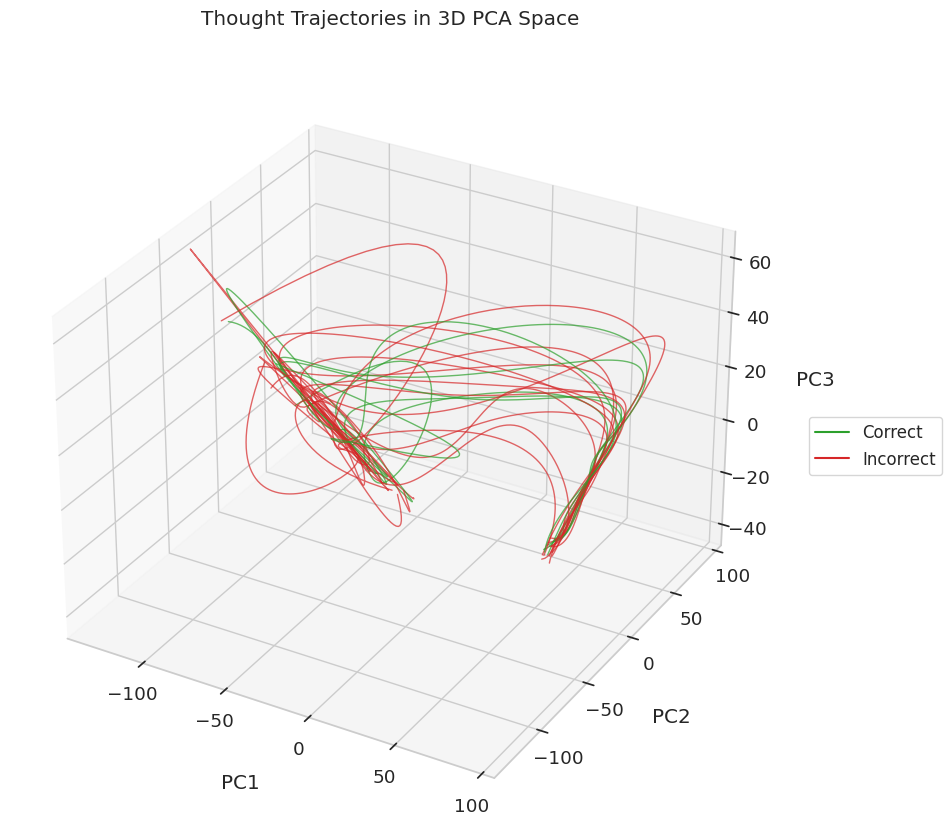

In [24]:
pca_traj, idxs, valid_runs = process_trajectories_for_pca(
    continuous_trajectories, token_trajectories, n_components=3
)

# Get correct/incorrect label for each trajectory
decoded_texts = []
for run_id in valid_runs:
    run_tokens = token_trajectories[run_id]
    all_token_ids = torch.cat([step for step in run_tokens], dim=0)
    decoded = tokenizer.decode(all_token_ids, skip_special_tokens=True)
    decoded_texts.append(decoded)

sample = dataset_farming[question_number]
reference = get_reference_math(sample)

run_correct = []
for output in decoded_texts:
    pred = extract_math_answer(output)
    reward = get_reward_math(pred, reference)
    run_correct.append(bool(reward))

fig = plt.figure(figsize=(12, 8))  # wider, taller
ax = fig.add_subplot(111, projection='3d')

# Track whether we've already labeled each type
color_map = {True: "tab:green", False: "tab:red"}

for i, run_id in enumerate(valid_runs):
    mask = (idxs == run_id)
    x, y, z = pca_traj[mask, 0], pca_traj[mask, 1], pca_traj[mask, 2]
    correct = run_correct[i]
    color = color_map[correct]
    label = "Correct" if correct else "Incorrect"
    label_to_use = label if not already[label] else None
    if label_to_use:
        already[label] = True

    if len(x) > 3:
        tck, u = splprep([x, y, z], s=0)
        u_fine = np.linspace(0, 1, 200)
        x_smooth, y_smooth, z_smooth = splev(u_fine, tck)
        ax.plot(x_smooth, y_smooth, z_smooth, color=color, alpha=0.7, linewidth=1.0, label=label_to_use)
    else:
        ax.plot(x, y, z, color=color, alpha=0.7, linewidth=1.0, label=label_to_use)

for correct, color in color_map.items():
    label = "Correct" if correct else "Incorrect"
    ax.plot([], [], [], color=color, label=label)  # Empty line just for legend
ax.legend(loc="center left", bbox_to_anchor=(1.04, 0.5), fontsize=12)

ax.set_title("Thought Trajectories in 3D PCA Space", pad=30)
ax.set_xlabel("PC1", labelpad=18)
ax.set_ylabel("PC2", labelpad=18)
ax.set_zlabel("PC3", labelpad=18)
ax.legend(loc="center left", bbox_to_anchor=(1.04, 0.5), fontsize=12)
plt.subplots_adjust(left=0.0, right=0.85, bottom=0.0, top=0.95)

#plt.savefig("plots/pca_trajectories_3d.png", dpi=300, bbox_inches="tight")

plt.show()

## Farming thought trajectories

Now we will create a dataset of thought trajectories.n_examples        = 2000
num_return_seqs   = 20
start_idx         = 0
min_steps_per_run = 4
max_steps_per_run = 14
checkpoint_every  = 50  # Save every 50 questions We will extract model responses for *n_examples* questions, running each question *num_return_seqs* times through the model, extract the distinct reasoning steps per each run, as well as the final answer.

In [75]:
# Configuring parameters
n_examples        = 2000
num_return_seqs   = 20
min_steps_per_run = 4
max_steps_per_run = 14  
checkpoint_every  = 50  # Save the pickle object every 50 questions

results = []

# The below function uses the helper functions we defined earlier for extracting ground truth answers and model answers.
# If using this with another dataset, replace the functions with your own custom ones.
def process_run(rid, cont_trajs, tok_trajs, tokenizer, reference, q, question_number):
    decoded_steps = [
        tokenizer.decode(tok, skip_special_tokens=True)
        for tok in tok_trajs[rid]
    ]
    step_vecs = [
        step.mean(0).squeeze(0).to(torch.float32).cpu().detach().numpy()
        for step in cont_trajs[rid]
    ]
    full_out = " ".join(decoded_steps)
    pred     = extract_math_answer(full_out)
    reward   = get_reward_math(pred, reference)
    hit      = reward == 1.0
    print(f"    Run {rid:2d}: predicted = {pred!s:12s} → "
          f"{'✅ CORRECT' if hit else '❌ WRONG'}")
    entry = {
        "question_number": question_number,
        "question_block": q,
        "reference":      reference,
        "predicted":      pred,
        "reward":         reward,
        "reasoning_steps": decoded_steps,
        "step_vectors":    step_vecs,
    }
    return entry, hit

processed_questions = 0

for question_number in range(0, n_examples):
    sample    = dataset_farming[question_number]
    reference = get_reference_math(sample)

    q = sample["problem"]
    prompt = prompt_style.format(problem=q)
    inputs = tokenizer([prompt], return_tensors="pt").to(model.device)
    input_length = inputs.input_ids.shape[1]

    outputs = miner.forward_pass(
        inputs=inputs,
        num_return_sequences=num_return_seqs
    )

    cont_trajs, tok_trajs = miner.get_continuous_thoughts(
        outputs=outputs,
        input_length=input_length
    )

    # Filter runs by step count and alignment
    valid = [
        rid for rid, (traj, tok) in enumerate(zip(cont_trajs, tok_trajs))
        if min_steps_per_run <= len(traj) <= max_steps_per_run
        and len(traj) == len(tok)
        and all(traj[i].size(0) == tok[i].size(0) for i in range(len(traj)))
    ]

    dropped = num_return_seqs - len(valid)
    kept    = len(valid)

    print(f"\nQuestion {question_number} — answer = {reference}")
    print(f"  → Dropped {dropped} runs, kept {kept}.")

    corr = wrong = 0
    for rid in valid:
        entry, hit = process_run(rid, cont_trajs, tok_trajs, tokenizer, reference, q, question_number)
        results.append(entry)
        if hit:
            corr += 1
        else:
            wrong += 1

    print(f"  Summary: {corr} correct, {wrong} wrong out of {kept} kept runs")

    processed_questions += 1
    if processed_questions == 15:
        break
    # Save checkpoint every N questions
    if processed_questions % checkpoint_every == 0:
        print(f"--- checkpointing after {processed_questions} questions ---")
        with open("results_math_checkpoint.pkl", "wb") as f:
            pickle.dump(results, f)

# Save final results
with open("results_math_final.pkl", "wb") as f:
    pickle.dump(results, f)


Question 0 — answer = 29.0
  → Dropped 2 runs, kept 18.
    Run  0: predicted = 28           → ❌ WRONG
    Run  1: predicted = 28           → ❌ WRONG
    Run  2: predicted = 28           → ❌ WRONG
    Run  4: predicted = 28           → ❌ WRONG
    Run  5: predicted = None         → ❌ WRONG
    Run  6: predicted = 28           → ❌ WRONG
    Run  7: predicted = 28           → ❌ WRONG
    Run  8: predicted = 28           → ❌ WRONG
    Run  9: predicted = 28           → ❌ WRONG
    Run 10: predicted = 28           → ❌ WRONG
    Run 11: predicted = 28           → ❌ WRONG
    Run 12: predicted = 28           → ❌ WRONG
    Run 13: predicted = 28           → ❌ WRONG
    Run 14: predicted = 28           → ❌ WRONG
    Run 15: predicted = 28           → ❌ WRONG
    Run 17: predicted = None         → ❌ WRONG
    Run 18: predicted = 28           → ❌ WRONG
    Run 19: predicted = 28           → ❌ WRONG
  Summary: 0 correct, 18 wrong out of 18 kept runs

Question 1 — answer = 20.0
  → Dropped 8 runs

# Training a reward model

#### Load our pickle object with the farmed trajectories and creating the dataset

In [25]:
with open("data/results_math_checkpoint.pkl", "rb") as f:
    results = pickle.load(f)

We group all runs by question number and only keep questions where the model gave both correct and incorrect answers (so, no questions where it always got them all right or all wrong). For each such “mixed” question, we keep just one example per unique predicted answer—no duplicates. This gives us a set with more variety, but it’s unbalanced (more wrong answers than right), which we’ll deal with later when training the reward model.

In [5]:
# Group runs by question number
by_question = defaultdict(list)
for entry in results:
    by_question[entry["question_number"]].append(entry)

# Filter to only include questions with both right and wrong answers
final_entries = []
for qnum, runs in by_question.items():
    has_right = any(r["reward"] == 1.0 for r in runs)
    has_wrong = any(r["reward"] == 0.0 for r in runs)
    if not (has_right and has_wrong):
        continue  # skip questions that aren't "mixed" - either all wrong or all right

    # For each unique predicted answer, keep just one run (first occurrence)
    seen_answers = set()
    for r in runs:
        ans = r["predicted"]
        if ans in seen_answers:
            continue
        final_entries.append(r)
        seen_answers.add(ans)

print(f"Built dataset of {len(final_entries)} unique answers from {len(by_question)} questions (mixed only: {sum(1 for q in by_question if any(r['reward']==1.0 for r in by_question[q]) and any(r['reward']==0.0 for r in by_question[q]))})")

# Let's see how many are correct/incorrect
n_pos = sum(1 for r in final_entries if r["reward"] == 1.0)
n_neg = sum(1 for r in final_entries if r["reward"] == 0.0)
print(f"Correct: {n_pos} | Incorrect: {n_neg} | Ratio: {n_pos/n_neg:.2f}")

Built dataset of 5873 unique answers from 1914 questions (mixed only: 1363)
Correct: 1389 | Incorrect: 4484 | Ratio: 0.31
Balanced: 2778 (Pos: 1389, Neg: 1389)


We take each trajectory and turn it into a fixed-length sequence: if a run has fewer steps, we pad it with zeros so every example has the same shape. Then we flatten these trajectories and try out different PCA dimensionalities (10, 50, 100, 500) to reduce the hidden state size. For each PCA setting, we train a simple LSTM-based reward model on the trajectories, using a weighted loss to help with class imbalance. The model is trained only on the training split and saved for each dimensionality—so we can later see which feature size works best.

In [9]:
max_steps = max_steps_per_run
pca_dims = [10, 50, 100, 500]

hidden_dim = final_entries[0]["step_vectors"][0].shape[0]
print(f"Final entries: {len(final_entries)} | hidden_dim: {hidden_dim}")

X_list, y_list = [], []
for e in final_entries:
    vecs = e["step_vectors"]
    if len(vecs) >= max_steps:
        sel = vecs[:max_steps]
    else:
        pad = [np.zeros(hidden_dim, dtype=np.float32)] * (max_steps - len(vecs))
        sel = vecs + pad
    X_list.append(np.stack(sel))       # (max_steps, hidden_dim)
    y_list.append(float(e["reward"]))

X = np.stack(X_list)                  # (N, max_steps, hidden_dim)
y = np.array(y_list)                  # (N,)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
N_train, T, D = X_train.shape
N_test = X_test.shape[0]

flat_train = X_train.reshape(N_train * T, D)
flat_test  = X_test.reshape(N_test  * T, D)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class RewardLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )
        self.cls = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        h_last = h_n[-1]
        return self.cls(h_last)

for n_comp in pca_dims:
    print(f"\n→ PCA → {n_comp} components")
    pca = PCA(n_components=n_comp)
    flat_train_red = pca.fit_transform(flat_train)           # (N_train*T, n_comp)
    flat_test_red  = pca.transform(flat_test)                # (N_test*T, n_comp)
    X_train_red = flat_train_red.reshape(N_train, T, n_comp)
    X_test_red  = flat_test_red.reshape(N_test,  T, n_comp)

    with open(f"models/pca_math_{n_comp}.pkl", "wb") as f:
        pickle.dump(pca, f)

    # Prepare DataLoader **on train only**
    X_tensor = torch.tensor(X_train_red, dtype=torch.float32)
    y_tensor = torch.tensor(y_train,    dtype=torch.float32).unsqueeze(1)
    loader   = DataLoader(TensorDataset(X_tensor, y_tensor), batch_size=32, shuffle=True)

    n_pos = (y_train == 1).sum()
    n_neg = (y_train == 0).sum()
    pos_weight = torch.tensor([n_neg / n_pos], dtype=torch.float32).to(device)

    # Initialize and train model
    model = RewardLSTM(input_dim=n_comp).to(device)
    opt   = torch.optim.Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight = pos_weight)

    for epoch in range(1, 12):
        model.train()
        tot = 0.0
        for bx, by in loader:
            bx, by = bx.to(device), by.to(device)
            opt.zero_grad()
            preds = model(bx)
            loss  = loss_fn(preds, by)
            loss.backward()
            opt.step()
            tot += loss.item()
        print(f"  [dim={n_comp}] Epoch {epoch:2d} — loss: {tot:.4f}")

    torch.save(model.state_dict(), f"models/reward_model_math_{n_comp}.pt")

Final entries: 5873 | hidden_dim: 2048

→ PCA → 10 components
  [dim=10] Epoch  1 — loss: 155.3724
  [dim=10] Epoch  2 — loss: 154.7183
  [dim=10] Epoch  3 — loss: 152.5813
  [dim=10] Epoch  4 — loss: 148.4209
  [dim=10] Epoch  5 — loss: 146.6575
  [dim=10] Epoch  6 — loss: 145.5187
  [dim=10] Epoch  7 — loss: 144.4176
  [dim=10] Epoch  8 — loss: 143.6163
  [dim=10] Epoch  9 — loss: 142.6560
  [dim=10] Epoch 10 — loss: 141.7213
  [dim=10] Epoch 11 — loss: 140.9657

→ PCA → 50 components
  [dim=50] Epoch  1 — loss: 155.5274
  [dim=50] Epoch  2 — loss: 155.0106
  [dim=50] Epoch  3 — loss: 152.6516
  [dim=50] Epoch  4 — loss: 146.8470
  [dim=50] Epoch  5 — loss: 142.3016
  [dim=50] Epoch  6 — loss: 139.0495
  [dim=50] Epoch  7 — loss: 135.9982
  [dim=50] Epoch  8 — loss: 133.4944
  [dim=50] Epoch  9 — loss: 130.6173
  [dim=50] Epoch 10 — loss: 127.7210
  [dim=50] Epoch 11 — loss: 125.3548

→ PCA → 100 components
  [dim=100] Epoch  1 — loss: 155.1330
  [dim=100] Epoch  2 — loss: 153.8291
 

For each PCA setting, we reload the corresponding dimensionality reduction and trained reward model, run the model on the test data, and compute metrics like accuracy, precision, recall, F1, and ROC AUC. We also print the confusion matrix and a detailed classification report, so we can see how well our reward model generalizes to new reasoning trajectories at different feature sizes.

In [10]:
for n_comp in pca_dims:
    print(f"\n=== Evaluating model with PCA {n_comp} components ===")

    # Load matching PCA transformer
    with open(f"models/pca_math_{n_comp}.pkl", "rb") as f:
        pca = pickle.load(f)

    flat_test_red  = pca.transform(flat_test)                # (N_test*T, n_comp)
    X_test_red  = flat_test_red.reshape(N_test,  T, n_comp)

    # Load trained model weights
    model = RewardLSTM(input_dim=n_comp).to(device)
    model.load_state_dict(torch.load(f"models/reward_model_math_{n_comp}.pt", map_location=device))
    model.eval()

    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test_red, dtype=torch.float32).to(device)
        logits = model(X_test_tensor)
        probs = torch.sigmoid(logits).cpu().numpy().flatten()
        # preds = model(X_test_tensor).cpu().numpy().flatten()

    threshold = 0.5  # You can adjust as needed
    y_pred_labels = (probs >= threshold).astype(int)

    print("Accuracy:", accuracy_score(y_test, y_pred_labels))
    print("Precision:", precision_score(y_test, y_pred_labels))
    print("Recall:", recall_score(y_test, y_pred_labels))
    print("F1:", f1_score(y_test, y_pred_labels))
    print("ROC AUC:", roc_auc_score(y_test, probs))
    print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred_labels))
    print("\nFull report:\n", classification_report(y_test, y_pred_labels))


=== Evaluating model with PCA 10 components ===
Accuracy: 0.6391489361702127
Precision: 0.3286384976525822
Recall: 0.5035971223021583
F1: 0.3977272727272727
ROC AUC: 0.6377774034952639

Confusion matrix:
 [[611 286]
 [138 140]]

Full report:
               precision    recall  f1-score   support

         0.0       0.82      0.68      0.74       897
         1.0       0.33      0.50      0.40       278

    accuracy                           0.64      1175
   macro avg       0.57      0.59      0.57      1175
weighted avg       0.70      0.64      0.66      1175


=== Evaluating model with PCA 50 components ===
Accuracy: 0.6757446808510639
Precision: 0.3611859838274933
Recall: 0.48201438848920863
F1: 0.41294298921417566
ROC AUC: 0.6518009672529534

Confusion matrix:
 [[660 237]
 [144 134]]

Full report:
               precision    recall  f1-score   support

         0.0       0.82      0.74      0.78       897
         1.0       0.36      0.48      0.41       278

    accuracy       